<a href="https://colab.research.google.com/github/raymondEDS/iFind_tech_team/blob/raymond-colabs/utilities%20/Clip_similiarty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script is meant to match clips with the longer raw footage. The bases of the code is from: https://aws.amazon.com/blogs/media/metfc-automatically-compare-two-videos-to-find-common-content/

In [ ]:
!pwd

/content


In [ ]:
#test
#import libraries
import numpy as np
import pandas as pd
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt
from tqdm import tqdm 

Remember to mount drive first.

The path to the entire raw file is:
/content/drive/MyDrive/ifind/Raw Footage/Dyad and Family /UI006/UI006.mp4


Path to clip is:
/content/drive/MyDrive/ifind/Training Video/1 FIND Unedited Clips/1. Sharing the Focus/UI006USF.mp4


In [ ]:

def clip_length(path):
  cap = cv.VideoCapture(path)
  length = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
  print( length )


def first_frame_of_clip(path):
  #input path to the clip, return image of first frame
  clip_obj = cv.VideoCapture(path)
  success, image = clip_obj.read()
  return image

def getPSNR(I1, I2):
  #https://docs.opencv.org/4.x/d5/dc4/tutorial_video_input_psnr_ssim.html
  #returns psnr (Peak signal-to-noise ratio)
    s1 = cv.absdiff(I1, I2) #|I1 - I2|
    s1 = np.float32(s1)     # cannot make a square on 8 bits
    s1 = s1 * s1            # |I1 - I2|^2
    sse = s1.sum()          # sum elements per channel
    if sse <= 1e-10:        # sum channels
        return 0            # for small values return zero
    else:
        shape = I1.shape
        mse = 1.0 * sse / (shape[0] * shape[1] * shape[2])
        psnr = 10.0 * np.log10((255 * 255) / mse)
        return psnr

def getMSSISM(i1, i2):
    #https://docs.opencv.org/4.x/d5/dc4/tutorial_video_input_psnr_ssim.html
    C1 = 6.5025
    C2 = 58.5225
    # INITS
    I1 = np.float32(i1) # cannot calculate on one byte large values
    I2 = np.float32(i2)
    I2_2 = I2 * I2 # I2^2
    I1_2 = I1 * I1 # I1^2
    I1_I2 = I1 * I2 # I1 * I2
    # END INITS
    # PRELIMINARY COMPUTING
    mu1 = cv.GaussianBlur(I1, (11, 11), 1.5)
    mu2 = cv.GaussianBlur(I2, (11, 11), 1.5)
    mu1_2 = mu1 * mu1
    mu2_2 = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_2 = cv.GaussianBlur(I1_2, (11, 11), 1.5)
    sigma1_2 -= mu1_2
    sigma2_2 = cv.GaussianBlur(I2_2, (11, 11), 1.5)
    sigma2_2 -= mu2_2
    sigma12 = cv.GaussianBlur(I1_I2, (11, 11), 1.5)
    sigma12 -= mu1_mu2
    t1 = 2 * mu1_mu2 + C1
    t2 = 2 * sigma12 + C2
    t3 = t1 * t2                    # t3 = ((2*mu1_mu2 + C1).*(2*sigma12 + C2))
    t1 = mu1_2 + mu2_2 + C1
    t2 = sigma1_2 + sigma2_2 + C2
    t1 = t1 * t2                    # t1 =((mu1_2 + mu2_2 + C1).*(sigma1_2 + sigma2_2 + C2))
    ssim_map = cv.divide(t3, t1)    # ssim_map =  t3./t1;
    mssim = cv.mean(ssim_map)       # mssim = average of ssim map
    return mssim

def resize_image_wrapper(image,dim=(640,360)):
  resized_image = cv.resize(image, (640,360), interpolation = cv.INTER_AREA)
  return resized_image

def find_match_start(raw_video_path, first_frame_of_clip):
  #returns df t
  raw_video = cv.VideoCapture(raw_video_path)
  trigger, image = raw_video.read()
  out=[]
  count= 0
  while trigger:
    d = {}
    image = resize_image_wrapper(image)
    first_frame_of_clip = resize_image_wrapper(first_frame_of_clip)
    d['PSNR'] = getPSNR(image,first_frame_of_clip)
    d['MSSISM'] = getMSSISM(image,first_frame_of_clip)
    d['count'] = count
    d['timestamp'] = raw_video.get(cv.CAP_PROP_POS_MSEC)
    out.append(d)
    trigger, image = raw_video.read()
    count += 1
    #print(count)

  df = pd.DataFrame(out)
  return df



In [ ]:
test = "/content/drive/MyDrive/ifind/Training Video/1 FIND Unedited Clips/1. Sharing the Focus/UI006USF.mp4"
test2 = '/content/drive/MyDrive/ifind/Raw Footage/Dyad and Family /UI006/UI006.mp4'



clip_length(test)
clip_length(test2)

#cv2_imshow(first_frame_of_clip(test))
#cv2_imshow(first_frame_of_clip(test2))

image1 = first_frame_of_clip(test)
image2 = first_frame_of_clip(test2)

resized_image1 = cv.resize(image1, (640,360), interpolation = cv.INTER_AREA)
print('image 1',image1.shape)
print('image 2',image2.shape)
print('resize image 1',resized_image1.shape)


x = getMSSISM(image2,resized_image1)
y = getPSNR(image2,resized_image1)
print(x)
print(y)


df = find_match_start(test2,image1)

df

286
27420
image 1 (720, 1280, 3)
image 2 (360, 640, 3)
resize image 1 (360, 640, 3)
(0.06333461351583704, 0.10882428030329251, 0.011047477827668154, 0.0)
6.2182083507632315


,PSNR,MSSISM,count,timestamp
0,6.218208,"(0.06333461351583704, 0.10882428030329251, 0.0...",0,0.0
1,6.218208,"(0.06333461351583704, 0.10882428030329251, 0.0...",1,40.0
2,6.218208,"(0.06333461351583704, 0.10882428030329251, 0.0...",2,80.0
3,6.218208,"(0.06333461351583704, 0.10882428030329251, 0.0...",3,120.0
4,6.218208,"(0.06333461351583704, 0.10882428030329251, 0.0...",4,160.0
...,...,...,...,...
27415,10.735690,"(0.4175588572034732, 0.3917200698153971, 0.454...",27415,1096600.0
27416,10.735055,"(0.41738137325458075, 0.3916061848534645, 0.45...",27416,1096640.0
27417,10.765782,"(0.4173588233097354, 0.3917518422017423, 0.454...",27417,1096680.0
27418,10.765942,"(0.41734759861963217, 0.39170048419214704, 0.4...",27418,1096720.0


In [ ]:
df.to_csv('output.csv', encoding = 'utf-8-sig') 


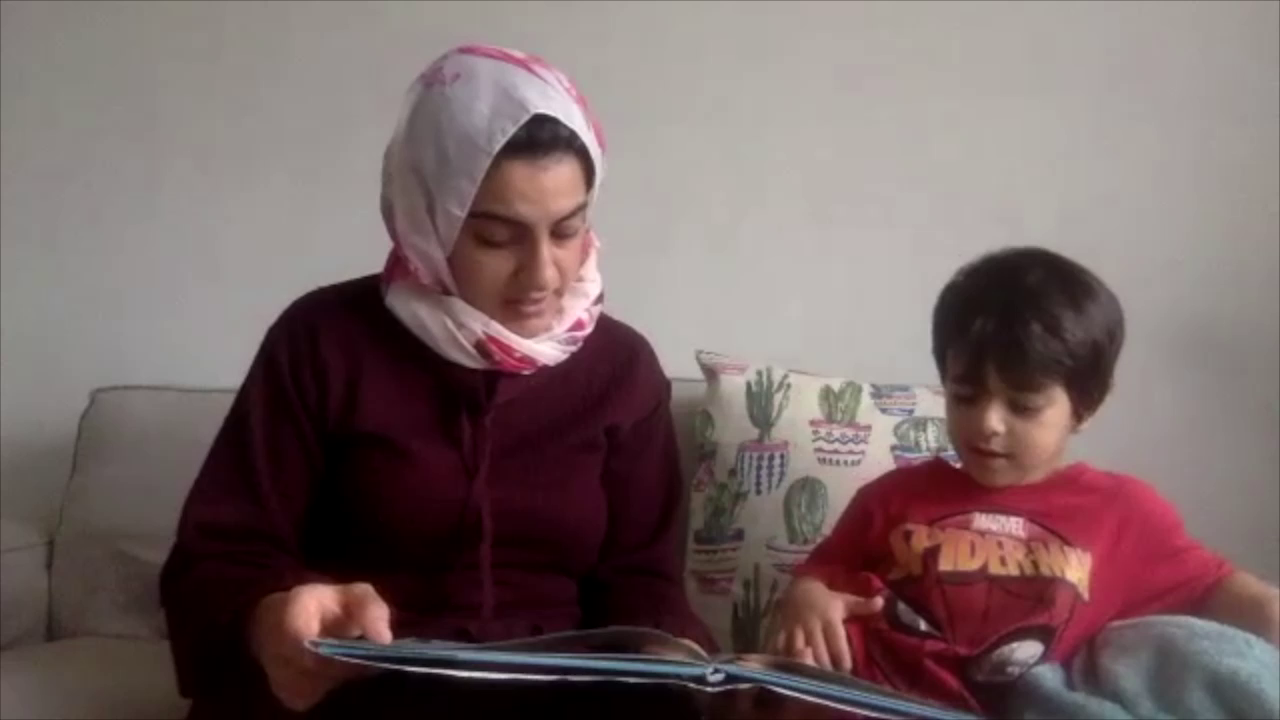

In [ ]:
cv2_imshow(first_frame_of_clip(test))